# Error analysis - elongation and area
The purpose of this notebook is to analyse and visualise two properties that might correlate with low/bad heights in the sample:
* Elongation, a measure of how stretched the property is. Elongation=1.0 represents a circle, Elongation=0.0 is a 2-dimensional line.
* Area in m2

An elongated building (with elongation factor closer to zero, I know, it's not very intuitive) or a building with small area is less likely to be a true building for the purposes of the energy model. 
Those buildings with both low height and low area/high elongation can probably be filtered from the database.

## Results
#### Elongation
* Over the entire European sample, elongation shows the same distribution for low buildings (<2.5m) and regular buildings. Other work indicates that this might not be so for individual regions.
* A cut-off of elongation < 0.125 is recommended for all buildings, and elongation < 0.2 for low buildings.

#### Area
* Area shows considerable differences in distribution between low and regular buildings. Low buildings tend to be small in area.
* A cut-off of area < 14m2 is recommended for all buildings, and 25 m2 for low buildings
* After applying the area filter, the frequency of low buildings changes from approximately 6% to 2.5%. Elongation reduces the frequency by another 0.1%.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dask_geopandas as dgp
import dask
import momepy as mp
import numpy as np

### Set up

In [2]:
parquet_dir = "./data/parquet/"

### Admininstrative areas
admin = pd.read_csv('./data/admin-codes-matches-v0.1.csv', dtype='str')
admin.drop('source', axis=1, inplace=True)

# Plot style, thanks to https://github.com/dhaitz
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Alternative
# plt.style.use('seaborn-v0_8-pastel')

## Elongated building distribution

In [3]:
def elong_func(df):
    return mp.Elongation(df).series

#### Dask routine

In [4]:
df = dgp.read_parquet(parquet_dir, index=False, columns=["id","height","geometry"])
df = df[df.height > 0]
# df = df[df.height < 2.5]

elong_bins = np.arange(0, 1, 0.05)
df["elongation"] = df.map_partitions(elong_func, meta=pd.Series(dtype=pd.Float64Dtype()))
df["elong_cat"] = df.elongation.map_partitions(pd.cut, elong_bins, meta=pd.Series(dtype=pd.CategoricalDtype()))
df["height_small"] = (df.height < 2.5)

df_group = df.groupby(["elong_cat", "height_small"], observed=True).elong_cat.count()

### Post calculations

In [5]:
dfc = df_group.compute()
dfc.index = dfc.index.set_levels(pd.IntervalIndex(dfc.index.levels[0]).left , level=0)
dfc = dfc.rename("percentage")
dfc = dfc.reset_index()

small_sum = dfc.percentage[dfc.height_small].sum()
tall_sum =  dfc.percentage[~dfc.height_small].sum()
dfc.percentage = np.where(dfc.height_small, dfc.percentage / small_sum, dfc.percentage / tall_sum)
dfc = dfc.rename(columns={"height_small": "smaller than 2.5 m"})


#### Plot elongation distribution

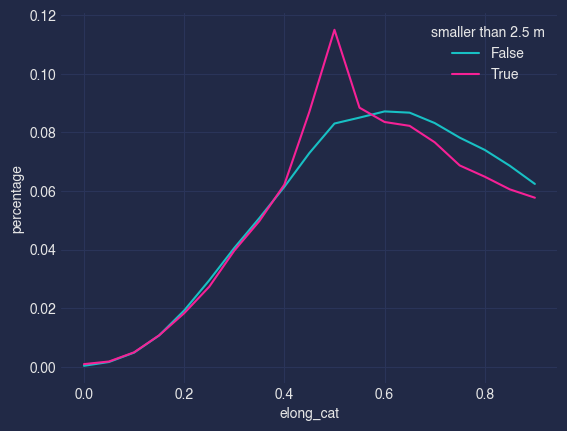

In [6]:

sns.lineplot(dfc, x="elong_cat", y="percentage", hue="smaller than 2.5 m");


Elongation does not correlate well with the height category, but we can still cut off the lower part of the distribution, which represent long, thin structures. elongation=1 is equivalent to a perfect circle, and rectangular building with sides ratio 1:8 would have an elongation = 0.125, with 1:5, the elongation would be 0.2. 

**I would suggest a lower cutoff of 0.125 or less for Elongation for all structures and cut-off of 0.2 for buildings with low height**

In [16]:
from shapely import box
print("A rectangle with sides 1:8 has an elongation factor = ")
print(mp.Elongation(gpd.GeoDataFrame(geometry=[box(0,0,1,8)])).series[0])

print("A rectangle with sides 1:5 has an elongation factor = ")
print(mp.Elongation(gpd.GeoDataFrame(geometry=[box(0,0,1,5)])).series[0])

A rectangle with sides 1:8 has an elongation factor = 
0.125
A rectangle with sides 1:5 has an elongation factor = 
0.2


## Small areas

We now investigate whether small (inhabitable) areas co-correlate with small heights. 

#### Dask routine

In [8]:
df = dgp.read_parquet(parquet_dir, index=False, columns=["id","height","geometry"])
df = df[df.height > 0]

area_bins = np.arange(0, 200, 5)
df["A"] = df.area
df["area_cat"] = df.A.map_partitions(pd.cut, area_bins, meta=pd.Series(dtype=pd.CategoricalDtype()))
df["height_small"] = df.height < 2.5

df_group = df.groupby(["area_cat", "height_small"]).area_cat.count()

### Post calculations

In [9]:
dfc = df_group.compute()
dfc.index = dfc.index.set_levels(pd.IntervalIndex(dfc.index.levels[0]).left , level=0)
dfc = dfc.rename("percentage")
dfc = dfc.reset_index()

small_sum = dfc.percentage[dfc.height_small].sum()
tall_sum =  dfc.percentage[~dfc.height_small].sum()
dfc.percentage = np.where(dfc.height_small, dfc.percentage / small_sum, dfc.percentage / tall_sum)
dfc = dfc.rename(columns={"height_small": "smaller than 2.5 m"})


#### Plot elongation distribution

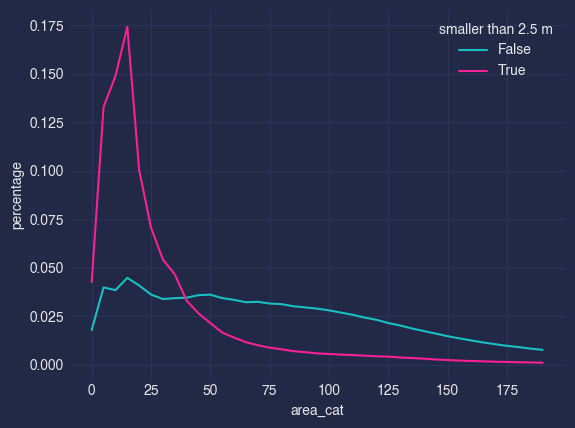

In [10]:
sns.lineplot(dfc, x="area_cat", y="percentage", hue="smaller than 2.5 m");

In [11]:
dfc.sort_values(by="percentage", ascending=False).head()

,area_cat,smaller than 2.5 m,percentage
7,15,True,0.174261
5,10,True,0.148801
3,5,True,0.132988
9,20,True,0.100389
11,25,True,0.070722


There is a very strong correlation between the heights category and area. Buildings lower than 2.5 m tend to be very small in area, with a peak around the minimal habitable area of 14-20 m2 for a one-person dwelling. This could be a suitable co-correlate for filtering out misidentifed structures.

**I would suggest a cutoff of 14 m2 for all structures and a cut-off of 25 m2 for buildings with low height.**

See: https://www.researchgate.net/publication/350969899_Housing_Spaces_in_Nine_European_Countries_A_Comparison_of_Dimensional_Requirements

In [19]:
## How many low height buildings remain once area and elongation cutoffs are applied?

df = dgp.read_parquet(parquet_dir, index=False, columns=["id","height","geometry"])
df["A"] = df.area
df["elongation"] = df.map_partitions(elong_func, meta=pd.Series(dtype=pd.Float64Dtype()))

df["H_filter"] = ((df.height < 2.5) & (df.height > 0))
df["A_filter"] = df.A < 25
df["E_filter"] = df.elongation <= 0.2

df = df[["H_filter","A_filter","E_filter"]]


Total = df.H_filter.count()
HF = df.H_filter.sum()
df_A = df[~df.A_filter]
AF = df_A.H_filter.sum()
df_E = df[~df.E_filter]
EF = df_E.H_filter.sum()

#Now both filters
df_A = df_A[~df_A.E_filter]
BOTH = df_A.H_filter.sum()



In [20]:
Total_c, HF_c, AF_c, EF_c, BOTH_c = dask.compute(Total, HF, AF, EF, BOTH)
print(Total_c, HF_c, AF_c, EF_c)

19840586 1176918 486754 1156551


In [26]:
values = [round(HF_c/Total_c*100,1), round(EF_c/Total_c*100,1), round(AF_c/Total_c*100,1),  round(BOTH_c/Total_c*100,1)]
labels = ["Low height buildings",  "... after elongation filter", "... after area filter", "... after both filters"]

pd.DataFrame({"filter": labels, "percentage": values})

,filter,percentage
0,Low height buildings,5.9
1,... after elongation filter,5.8
2,... after area filter,2.5
3,... after both filters,2.4


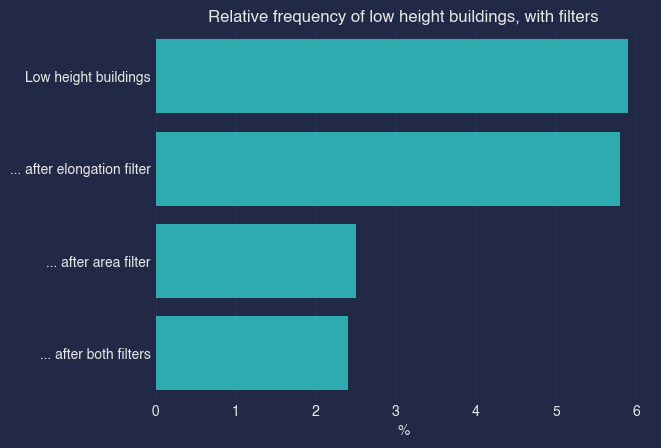

In [34]:
fig = sns.barplot(y=labels, x=values);
fig.set_title("Relative frequency of low height buildings, with filters");
fig.set_xlabel("%");
# fig.tick_params(axis='x', rotation=20);

Thus, buildings with low height and low area (< 2.5m and < 25m2) make up around 3.4% of all buildings, but 2.5% buildings with low height remain. Elongation has little additional effect (0.1%), but may be useful to help filter buildings in some regions (check Switzerland).